In [2]:
import os 
import calendar

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [ ]:
years = range(2005, 2015) # all years from 2005-2014 (10 year span)
directory_path = '/projects/lortizur/cop_climate/era5/' # for original data files

# create list of file names from directory by checking for year within range defined above
# file name looks like: 'directory_path+download_daily_maximum_2m_temperature_2005_01.nc'
# each file contains data from each day during that month within that year
files_list = [directory_path+f for f in os.listdir(directory_path) if int(f[-10:-6]) in years]

# open list of files as single dataset 
ds = xr.open_mfdataset(files_list)

# convert K to ºC
ds['t2m'] = (ds['t2m'] - 273.15).assign_attrs(units='degC')

# group data by month, calculate mean per month
ds_month_mean = ds.groupby('time.month').mean()

# save file with grouped mean calculation to disk to improve performance
ds_month_mean.to_netcdf('/home/alawyer2/era5-data/monthly-means.nc')

# access local mean file, save to variable
local_mean_file = xr.open_dataset('/home/alawyer2/era5-data/monthly-means.nc')

<xarray.DataArray 'month' (month: 12)> Size: 96B
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
    realization  int64 8B ...
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 0.95, 'Average monthly temperature (ºC at 2m)')

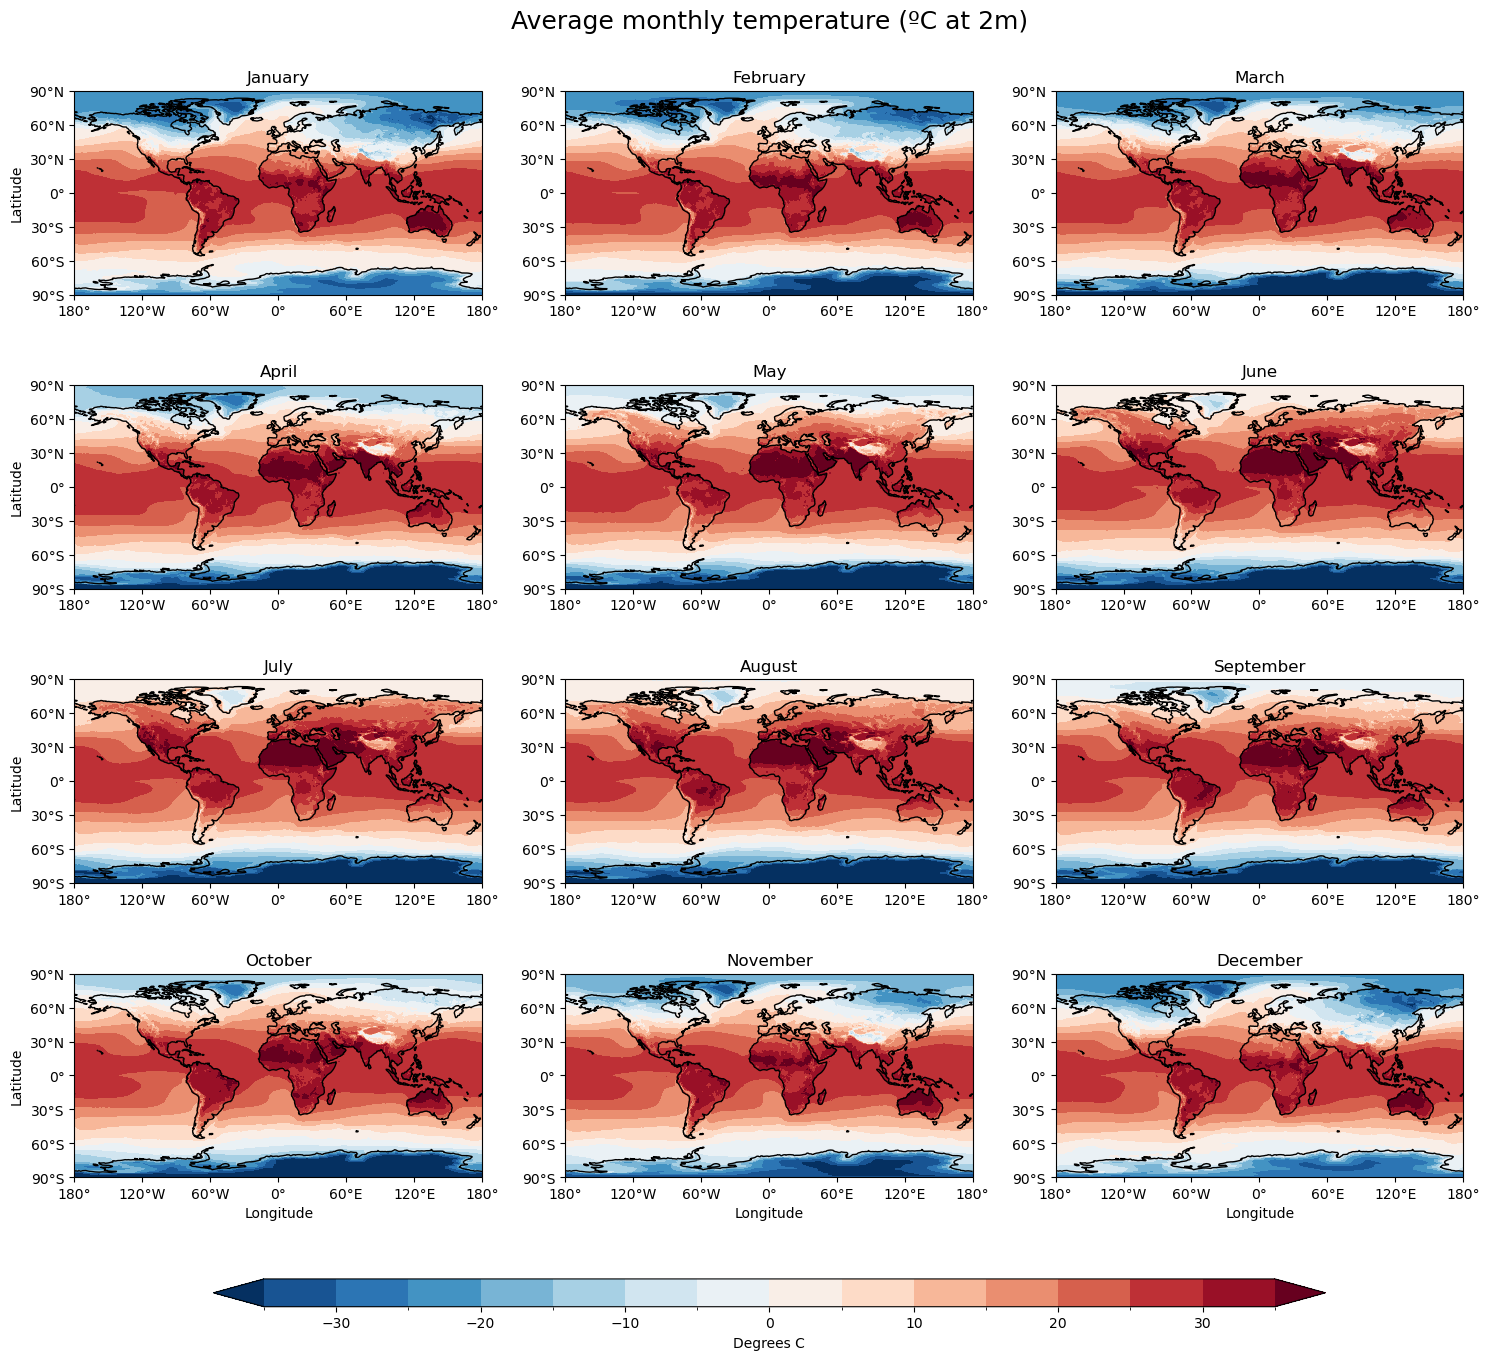

In [18]:
# fig = plt.figure(figsize=(11, 8.5))

# Set levels for countours and colorbar
clevs = np.arange(-35, 36, 5)

# Create facet grid for each month
fg = local_mean_file['t2m'].plot.contourf(
    levels=clevs,
    row='month',
    col_wrap=3,
    aspect=1.1,
    size=4,
    robust=True,
    cmap='RdBu_r',
    extend='both',
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={
        "location": "bottom",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Degrees C",
    },
)

# Set labels at bottom of columns and left side of rows
fg.set_xlabels('Longitude')
fg.set_ylabels('Latitude')

for ax, month_value in zip(fg.axs.flat, local_mean_file['month'].values):
    ax.coastlines()
    # Set title on each plot
    ax.set_title(calendar.month_name[month_value])
    
    # Longitude labels
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xlim(right=181) # right-most 180º tick mark wasn't showing up without this line

    # Latitude labels
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

# Add spacing to make it look pretty
plt.subplots_adjust(wspace=0.2, bottom=0.22)
# Add and position chart title
plt.suptitle('Average monthly temperature (ºC at 2m)', fontsize=18, y=0.95)